In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from os import listdir
import random

import scipy.cluster.hierarchy as sch
from scipy import stats

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *

In [2]:
### READ DATA ###

data, person_id = [], []
for txt in listdir('Walk_MODEL'):
    measure = pd.read_csv('Walk_MODEL/'+txt, sep=' ', header=None).values
    data.append(measure)
    person_id.append(txt.split('-')[-1].split('.')[0])

data = np.asarray(data)
data.shape

(20, 170, 3)

In [3]:
# data = np.zeros((100, 170, 3))
# person_id = []
# for i in range(data.shape[0]):
#     for j in range(data.shape[2]):
#         data[i, :, j] = np.random.normal((i%5 * 40 + 20), 3, data.shape[1])
#     person_id.append(1)
# for j in range(data.shape[2]):
#         data[15, :, j] = np.random.normal((40 + 20), 3, data.shape[1])
# person_id[15] = 0

Text(0.5, 0, 'Time')

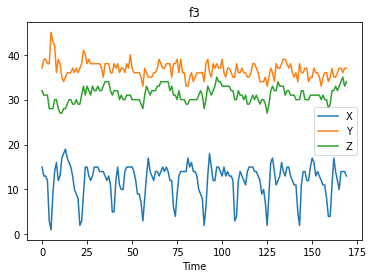

In [4]:
### EXEMPLE OF DATA FOR A SINGLE INDIVIDUAL ###

plt.plot(data[11])
plt.legend(['X','Y','Z'])
plt.title(person_id[11]); plt.xlabel('Time')

In [5]:
for i,s in enumerate(data):
    data[i] = (data[i] - s.mean(axis=0)) / s.std(axis=0)

# DIMENSIONALITY REDUCTION

In [6]:
def get_autoencoder(data):

    input_layer = Input(shape=(data.shape[1], data.shape[2]))
    
    encoder = TimeDistributed(Dense(200, activation='tanh'))(input_layer)
    encoder = TimeDistributed(Dense(50, activation='tanh'))(encoder)
    latent = TimeDistributed(Dense(10, activation='tanh'))(encoder)
    decoder = TimeDistributed(Dense(50, activation='tanh'))(latent)
    decoder = TimeDistributed(Dense(200, activation='tanh'))(decoder)

    out = TimeDistributed(Dense(3))(decoder)

    autoencoder = Model(inputs=input_layer, outputs=out)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

In [7]:
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

es = EarlyStopping(monitor='val_loss', mode='auto', restore_best_weights=True, verbose=1, patience=0)
autoencoder = get_autoencoder(data)
autoencoder.fit(data[:10],data[:10], epochs=1000, verbose=2, validation_data=(data[:10],data[:10]), callbacks=[es])

Epoch 1/1000
1/1 - 0s - loss: 0.4554 - val_loss: 0.3788
Epoch 2/1000
1/1 - 0s - loss: 0.3788 - val_loss: 0.3088
Epoch 3/1000
1/1 - 0s - loss: 0.3088 - val_loss: 0.2441
Epoch 4/1000
1/1 - 0s - loss: 0.2441 - val_loss: 0.1857
Epoch 5/1000
1/1 - 0s - loss: 0.1857 - val_loss: 0.1361
Epoch 6/1000
1/1 - 0s - loss: 0.1361 - val_loss: 0.0978
Epoch 7/1000
1/1 - 0s - loss: 0.0978 - val_loss: 0.0718
Epoch 8/1000
1/1 - 0s - loss: 0.0718 - val_loss: 0.0574
Epoch 9/1000
1/1 - 0s - loss: 0.0574 - val_loss: 0.0522
Epoch 10/1000
Restoring model weights from the end of the best epoch.
1/1 - 0s - loss: 0.0522 - val_loss: 0.0529
Epoch 00010: early stopping


In [8]:
data[11].shape

(170, 3)

Text(0, 0.5, 'mse')

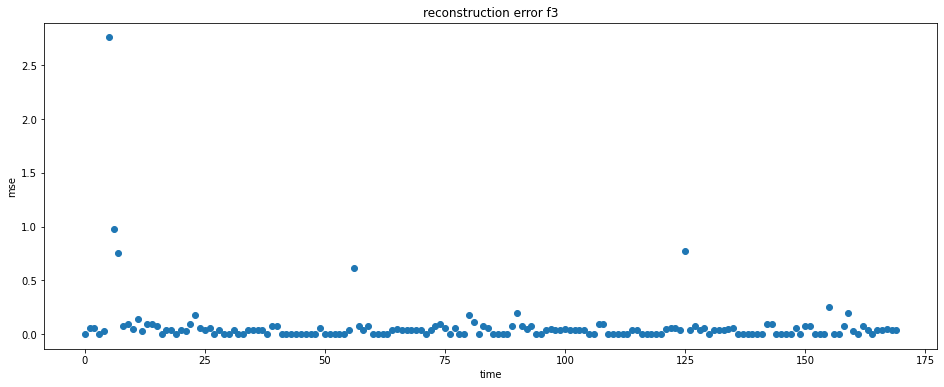

In [9]:
### TRY TO RECONSTRUCT ERRORS ###

predictions = autoencoder.predict(np.expand_dims(data[11], axis=0))
mse = np.mean(np.power(data[11] - predictions, 2), axis=2)

plt.figure(figsize=(16,6))
plt.scatter(range(data.shape[1]), mse)
plt.title('reconstruction error '+str(person_id[11]))
plt.xlabel('time'); plt.ylabel('mse')

In [11]:
df_ = np.mean(np.power(data[10:] - autoencoder.predict(data[10:]), 2), axis=2)
# df = encoder_model.predict(data[10:])

In [12]:
df_.shape

(10, 170)

In [13]:
corr = np.zeros((df.shape[0], df.shape[0]))
for i in range(df.shape[2]):
    corr += np.corrcoef(df[:,:,i])
corr = corr/df.shape[2]

NameError: name 'df' is not defined

# Pearson Correlation CLUSTERING

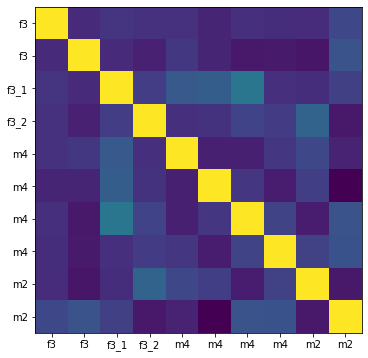

In [14]:
# ### COMPUTE CORRELATION MATRIX ###

df = np.mean(np.power(data[10:] - autoencoder.predict(data[10:]), 2), axis=2)
corr = np.corrcoef(df)
# df = encoder_model.predict(data[10:])

# corr = np.zeros((df.shape[0], df.shape[0]))
# for i in range(df.shape[2]):
#     corr += np.corrcoef(df[:,:,i])
# corr = corr/df.shape[2]

plt.figure(figsize=(6,6))
plt.imshow(corr)
plt.xticks(range(len(person_id[10:])), person_id[10:])
plt.yticks(range(len(person_id[10:])), person_id[10:])
np.set_printoptions(False)

In [15]:
### HIERACHICAL CLUSTERING ###

d = sch.distance.pdist(corr)
L = sch.linkage(d, method='ward')
ind = sch.fcluster(L, d.max(), 'distance')
dendrogram = sch.dendrogram(L, no_plot=True)

df = [df[i] for i in dendrogram['leaves']]
labels = [person_id[10:][i] for i in dendrogram['leaves']]


In [16]:
df = np.array(df)

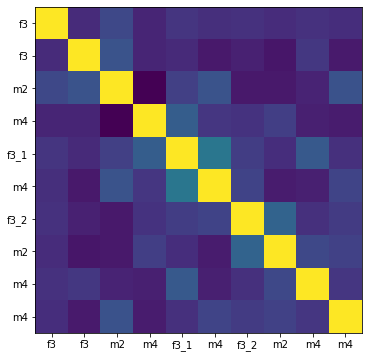

In [17]:
corr = np.corrcoef(df)

# corr = np.zeros((df.shape[0], df.shape[0]))
# for i in range(df.shape[2]):
#     corr += np.corrcoef(df[:,:,i])
# corr = corr/df.shape[2]

plt.figure(figsize=(6,6))
plt.imshow(corr)
plt.xticks(range(len(person_id[10:])), labels)
plt.yticks(range(len(person_id[10:])), labels)
np.set_printoptions(False)

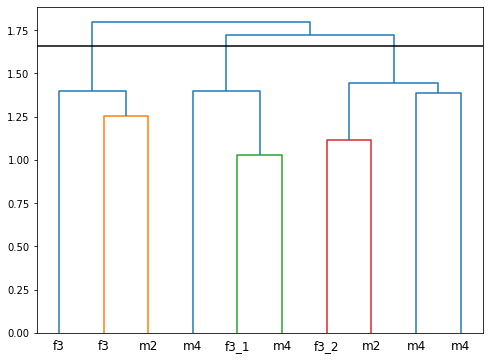

In [18]:
### PLOT DENDROGRAM ###

plt.figure(figsize=(8,6))
dendrogram = sch.dendrogram(L, labels=person_id[10:])
plt.axhline(d.max(), c='black')

In [19]:
person_id

['f1_1',
 'f1_2',
 'f1_3',
 'f1_4',
 'f1_5',
 'm1_1',
 'm1_2',
 'm2_1',
 'm2_2',
 'f3',
 'f3',
 'f3',
 'f3_1',
 'f3_2',
 'm4',
 'm4',
 'm4',
 'm4',
 'm2',
 'm2']

# Kolmogorov-Smirnov CLUSTERING

In [20]:
def KScoeff(df):
    
    ks_matrix = np.zeros((len(df),len(df)))
    for i in range(len(df)):
        for j in range(i+1,len(df)):
            ks_test = stats.ks_2samp(df[i], df[j])
            ks_matrix[i,j] = ks_test.statistic
            ks_matrix[j,i] = ks_test.statistic
            
    return ks_matrix

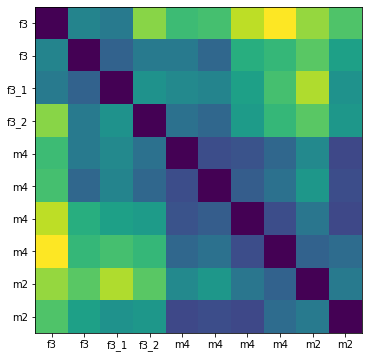

In [21]:
### COMPUTE KOLMOGOROV SMIRNOV MATRIX ###

df = np.mean(np.power(data[10:] - autoencoder.predict(data[10:]), 2), axis=2)
ks_matrix = KScoeff(df)

# df = encoder_model.predict(data[10:])

# ks_matrix = np.zeros((df.shape[0], df.shape[0]))
# for i in range(df.shape[2]):
#     ks_matrix += KScoeff(df[:,:,i])
# ks_matrix = ks_matrix/df.shape[2]

plt.figure(figsize=(6,6))
plt.imshow(ks_matrix)
plt.xticks(range(len(person_id[10:])), person_id[10:])
plt.yticks(range(len(person_id[10:])), person_id[10:])
np.set_printoptions(False)

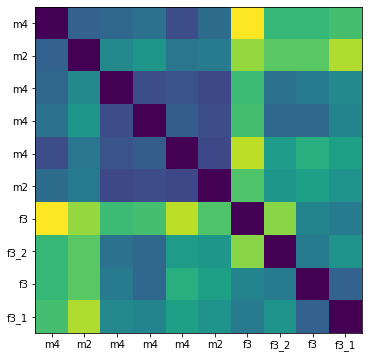

In [22]:
### HIERACHICAL CLUSTERING ###

d = sch.distance.pdist(ks_matrix)
L = sch.linkage(d, method='ward')
ind = sch.fcluster(L, d.max(), 'distance')
dendrogram = sch.dendrogram(L, no_plot=True)

df = [df[i] for i in dendrogram['leaves']]
labels = [person_id[10:][i] for i in dendrogram['leaves']]

df = np.array(df)

ks_matrix = KScoeff(df)
# ks_matrix = np.zeros((df.shape[0], df.shape[0]))
# for i in range(df.shape[2]):
#     ks_matrix += KScoeff(df[:,:,i])
# ks_matrix = ks_matrix/df.shape[2]

plt.figure(figsize=(6,6))
plt.imshow(ks_matrix)
plt.xticks(range(len(person_id[10:])), labels)
plt.yticks(range(len(person_id[10:])), labels)
np.set_printoptions(False)

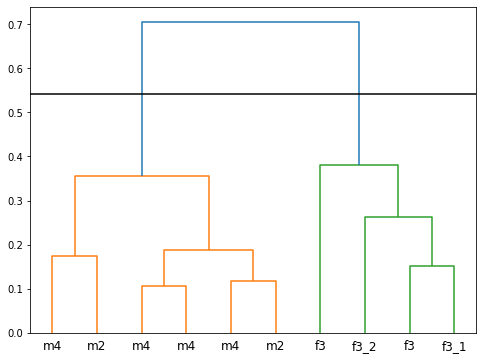

In [23]:
### PLOT DENDROGRAM ###

plt.figure(figsize=(8,6))
dendrogram = sch.dendrogram(L, labels=person_id[10:])
plt.axhline(d.max(), c='black')